In [1]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import csep
from csep.utils import time_utils
from matplotlib.lines import Line2D
from csep.core.forecasts import GriddedForecast
from cartopy.io import img_tiles
from csep.core.regions import CartesianGrid2D
import time
import warnings
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
warnings.filterwarnings('ignore')

In [2]:

def read_GEAR1_format(filename, area_filename, magnitudes):
    """filename"""
    # long, lat, >=4.95, >=5.0, ..., >= 8.95
    t0 = time.time()
    bulk_data = np.loadtxt(filename, skiprows=1, delimiter=',')
    
    # construction region information
    lons = bulk_data[:,1]
    lats = bulk_data[:,2]
    coords = np.column_stack([lons, lats])
    
    # coordinates are given as midpoints origin should be in the 'lower left' corner
    r = CartesianGrid2D.from_origins(coords, magnitudes=magnitudes)
    
    # shape: (num_space_bins, num_mag_bins)
    bulk_data_no_coords = bulk_data[:, 3:]
    
    # tono's format provides cumulative rates per meter**2
    incremental_yrly_density = np.diff(np.fliplr(bulk_data_no_coords))
    
    # computing the differences, but returning array with the same shape
    incremental_yrly_density = np.column_stack([np.fliplr(incremental_yrly_density), bulk_data_no_coords[:,-1]])
    
    # read in area to denormalize back onto csep grid
    area = np.loadtxt(area_filename, skiprows=1, delimiter=',')

    # allows us to use broadcasting
    m2_per_cell = np.reshape(area[:,-1], (len(area[:,1]), 1))
    incremental_yrly_rates = incremental_yrly_density * m2_per_cell
    
    return incremental_yrly_rates, r, magnitudes

def _get_basemap(basemap):

    if basemap == 'stamen_terrain':
        tiles = img_tiles.Stamen('terrain')
    elif basemap == 'stamen_terrain-background':
        tiles = img_tiles.Stamen('terrain-background')
    elif basemap == 'google-satellite':
        tiles = img_tiles.GoogleTiles(style='satellite')
    elif basemap == 'ESRI_terrain':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Terrain_Base/'                  'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    elif basemap == 'ESRI_imagery':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/'                  'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    elif basemap == 'ESRI_relief':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/'                  'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    elif basemap == 'ESRI_topo':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/'                  'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    else:
        raise ValueError('Basemap type not valid or not implemented')

    return tiles

In [3]:
# Load data
area_fnameW = './data/area.dat'
GEAR1_fnameW = './data/GEAR1.dat'


bulk_dataW = np.loadtxt(GEAR1_fnameW, skiprows=1, delimiter=',')
bulk_areaW = np.loadtxt(area_fnameW, skiprows=1, delimiter=',')


In [4]:
lonsW = bulk_dataW[:,0] 
latsW = bulk_dataW[:,1]
m595 = bulk_dataW[:,2] 
m605 = bulk_dataW[:,3] 
m615 = bulk_dataW[:,4] 
m625 = bulk_dataW[:,5] 
m635 = bulk_dataW[:,6] 
m645 = bulk_dataW[:,7] 
m655 = bulk_dataW[:,8] 
m665 = bulk_dataW[:,9] 
m675 = bulk_dataW[:,10] 
m685 = bulk_dataW[:,11] 
m695 = bulk_dataW[:,12] 
m705 = bulk_dataW[:,13] 
m715 = bulk_dataW[:,14] 
m725 = bulk_dataW[:,15] 
m735 = bulk_dataW[:,16] 
m745 = bulk_dataW[:,17] 
m755 = bulk_dataW[:,18] 
m765 = bulk_dataW[:,19] 
m775 = bulk_dataW[:,20] 
m785 = bulk_dataW[:,21] 
m795 = bulk_dataW[:,22] 
m805 = bulk_dataW[:,23] 
m815 = bulk_dataW[:,24] 
m825 = bulk_dataW[:,25] 
m835 = bulk_dataW[:,26] 
m845 = bulk_dataW[:,27] 
m855 = bulk_dataW[:,28] 
m865 = bulk_dataW[:,29] 
m875 = bulk_dataW[:,30] 
m885 = bulk_dataW[:,31] 
m895 = bulk_dataW[:,32]




GEAR1 = pd.DataFrame()
GEAR1['longitude'] = lonsW
GEAR1['latitude'] = latsW
GEAR1['m595'] = m595
GEAR1['m605'] = m605 
GEAR1['m615'] = m615 
GEAR1['m625'] = m625 
GEAR1['m635'] = m635 
GEAR1['m645'] = m645 
GEAR1['m655'] = m655 
GEAR1['m665'] = m665 
GEAR1['m675'] = m675 
GEAR1['m685'] = m685 
GEAR1['m695'] = m695 
GEAR1['m705'] = m705 
GEAR1['m715'] = m715 
GEAR1['m725'] = m725 
GEAR1['m735'] = m735 
GEAR1['m745'] = m745 
GEAR1['m755'] = m755 
GEAR1['m765'] = m765 
GEAR1['m775'] = m775 
GEAR1['m785'] = m785 
GEAR1['m795'] = m795 
GEAR1['m805'] = m805 
GEAR1['m815'] = m815 
GEAR1['m825'] = m825 
GEAR1['m835'] = m835 
GEAR1['m845'] = m845 
GEAR1['m855'] = m855 
GEAR1['m865'] = m865 
GEAR1['m875'] = m875 
GEAR1['m885'] = m885 
GEAR1['m895'] = m895




In [5]:
cell_areaW = bulk_areaW[:,2]

area = pd.DataFrame()
area['longitude'] = lonsW
area['latitude'] = latsW
area['area'] = cell_areaW


GEAR1_NZlon = GEAR1[(GEAR1['longitude'] > 164.5) & (GEAR1['longitude'] < 179.5)]
GEAR1_NZlat = GEAR1_NZlon[(GEAR1_NZlon['latitude'] > -48.5) & (GEAR1_NZlon['latitude'] < -33.5)]


area_NZlon = area[(area['longitude'] > 164.5) & (area['longitude'] < 179.5)]
area_NZlat = area_NZlon[(area_NZlon['latitude'] > -48.5) & (area_NZlon['latitude'] < -33.5)]


# save data
GEAR1_NZlat.to_csv('./data/GEAR1_around_NZ.dat')
area_NZlat.to_csv('./data/areas_around_NZ.dat')



area_fnameNZ = './data/areas_around_NZ.dat'
fore_fnameNZ = './data/GEAR1_around_NZ.dat'


bulk_dataNZ = np.loadtxt(fore_fnameNZ, skiprows=1, delimiter=',')
bulk_areaNZ = np.loadtxt(area_fnameNZ, skiprows=1, delimiter=',')



cell_areaNZ = bulk_areaNZ[:,3]
b_NZ = 1.0
dh = 0.1
offset = dh / 2
lonsNZ = bulk_dataNZ[:,1] - offset
latsNZ = bulk_dataNZ[:,2] - offset



In [6]:
m595NZ = bulk_dataNZ[:,3] 
m605NZ = bulk_dataNZ[:,4] 
m615NZ = bulk_dataNZ[:,5] 
m625NZ = bulk_dataNZ[:,6] 
m635NZ = bulk_dataNZ[:,7] 
m645NZ = bulk_dataNZ[:,8] 
m655NZ = bulk_dataNZ[:,9] 
m665NZ = bulk_dataNZ[:,10] 
m675NZ = bulk_dataNZ[:,11] 
m685NZ = bulk_dataNZ[:,12] 
m695NZ = bulk_dataNZ[:,13] 
m705NZ = bulk_dataNZ[:,14] 
m715NZ = bulk_dataNZ[:,15] 
m725NZ = bulk_dataNZ[:,16] 
m735NZ = bulk_dataNZ[:,17] 
m745NZ = bulk_dataNZ[:,18] 
m755NZ = bulk_dataNZ[:,19] 
m765NZ = bulk_dataNZ[:,20] 
m775NZ = bulk_dataNZ[:,21] 
m785NZ = bulk_dataNZ[:,22] 
m795NZ = bulk_dataNZ[:,23] 
m805NZ = bulk_dataNZ[:,24] 
m815NZ = bulk_dataNZ[:,25] 
m825NZ = bulk_dataNZ[:,26] 
m835NZ = bulk_dataNZ[:,27] 
m845NZ = bulk_dataNZ[:,28] 
m855NZ = bulk_dataNZ[:,29] 
m865NZ = bulk_dataNZ[:,30] 
m875NZ = bulk_dataNZ[:,31] 
m885NZ = bulk_dataNZ[:,32] 
m895NZ = bulk_dataNZ[:,33] 

In [7]:
GEAR1_NZ = pd.DataFrame() 
GEAR1_NZ['longitude'] = np.round(lonsNZ,1)
GEAR1_NZ['latitude'] = np.round(latsNZ,1)
GEAR1_NZ['m495'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 4.95))))
GEAR1_NZ['m505'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.05))))
GEAR1_NZ['m515'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.15))))
GEAR1_NZ['m525'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.25))))
GEAR1_NZ['m535'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.35))))
GEAR1_NZ['m545'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.45))))
GEAR1_NZ['m555'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.55))))
GEAR1_NZ['m565'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.65))))
GEAR1_NZ['m575'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.75))))
GEAR1_NZ['m585'] = ((m595NZ * 5.0) / (10**(-b_NZ *(5.95 - 5.85))))
GEAR1_NZ['m595'] = m595NZ * 5.0
GEAR1_NZ['m605'] = m605NZ * 5.0
GEAR1_NZ['m615'] = m615NZ * 5.0
GEAR1_NZ['m625'] = m625NZ * 5.0
GEAR1_NZ['m635'] = m635NZ * 5.0
GEAR1_NZ['m645'] = m645NZ * 5.0
GEAR1_NZ['m655'] = m655NZ * 5.0
GEAR1_NZ['m665'] = m665NZ * 5.0
GEAR1_NZ['m675'] = m675NZ * 5.0
GEAR1_NZ['m685'] = m685NZ * 5.0
GEAR1_NZ['m695'] = m695NZ * 5.0
GEAR1_NZ['m705'] = m705NZ * 5.0
GEAR1_NZ['m715'] = m715NZ * 5.0
GEAR1_NZ['m725'] = m725NZ * 5.0
GEAR1_NZ['m735'] = m735NZ * 5.0
GEAR1_NZ['m745'] = m745NZ * 5.0
GEAR1_NZ['m755'] = m755NZ * 5.0
GEAR1_NZ['m765'] = m765NZ * 5.0
GEAR1_NZ['m775'] = m775NZ * 5.0
GEAR1_NZ['m785'] = m785NZ * 5.0
GEAR1_NZ['m795'] = m795NZ * 5.0
GEAR1_NZ['m805'] = m805NZ * 5.0
GEAR1_NZ['m815'] = m815NZ * 5.0
GEAR1_NZ['m825'] = m825NZ * 5.0
GEAR1_NZ['m835'] = m835NZ * 5.0
GEAR1_NZ['m845'] = m845NZ * 5.0
GEAR1_NZ['m855'] = m855NZ * 5.0
GEAR1_NZ['m865'] = m865NZ * 5.0
GEAR1_NZ['m875'] = m875NZ * 5.0
GEAR1_NZ['m885'] = m885NZ * 5.0
GEAR1_NZ['m895'] = m895NZ * 5.0

In [8]:
mw_min = 4.95
mw_max = 8.95
dmw = 0.1
mws = np.arange(mw_min, mw_max+dmw/2, dmw)

start_date = time_utils.strptime_to_utc_datetime('2014-01-01 00:00:00.0')
end_date = time_utils.strptime_to_utc_datetime('2022-01-01 00:00:00.0')
duration = (end_date - start_date) # in days
duration =  round(duration.days / 365.25,2) # in years
ofp = 5.0 # original forecast period (in years)
factor = duration / ofp # scaling factor


In [9]:
# Read the 3 NZ forecast 
NZHM = './data/NZHM_5year_rates-fromXML.dat'

NZHM_f = csep.load_gridded_forecast(NZHM, start_date=start_date, end_date=end_date, name='NZHM').scale(factor)

NZ = pd.DataFrame()
NZ['longitude'] = NZHM_f.get_longitudes()
NZ['latitude'] = NZHM_f.get_latitudes()

# using coordinates for existing nz forecast to clip GEAR 
GEAR1_CSEPNZ = pd.merge(NZ, GEAR1_NZ, how="inner", on=['longitude', 'latitude'])


GEAR1_CSEPNZ.to_csv('./data/GEAR1495_NZ.dat')

# Define NZ CSEP area
NZCSEP_area = pd.DataFrame()
NZCSEP_area['longitude'] = np.round(lonsNZ,1)
NZCSEP_area['latitude'] = np.round(latsNZ,1)
NZCSEP_area['area'] = cell_areaNZ 



GEAR1_CSEPNZa = pd.merge(NZ, NZCSEP_area, how="inner", on=['longitude', 'latitude'])
GEAR1_CSEPNZa.to_csv('./data/GEAR1a_NZ.dat')

In [10]:
area_fname_NZ = './data/GEAR1a_NZ.dat'
fname_NZ = './data/GEAR1495_NZ.dat'

In [11]:

GEAR1NZ_f = GriddedForecast.from_custom(read_GEAR1_format, name='GEAR1', func_args=(fname_NZ, area_fname_NZ, mws)).scale(factor)



## Plotting global and regional seismicity forecasts on a map

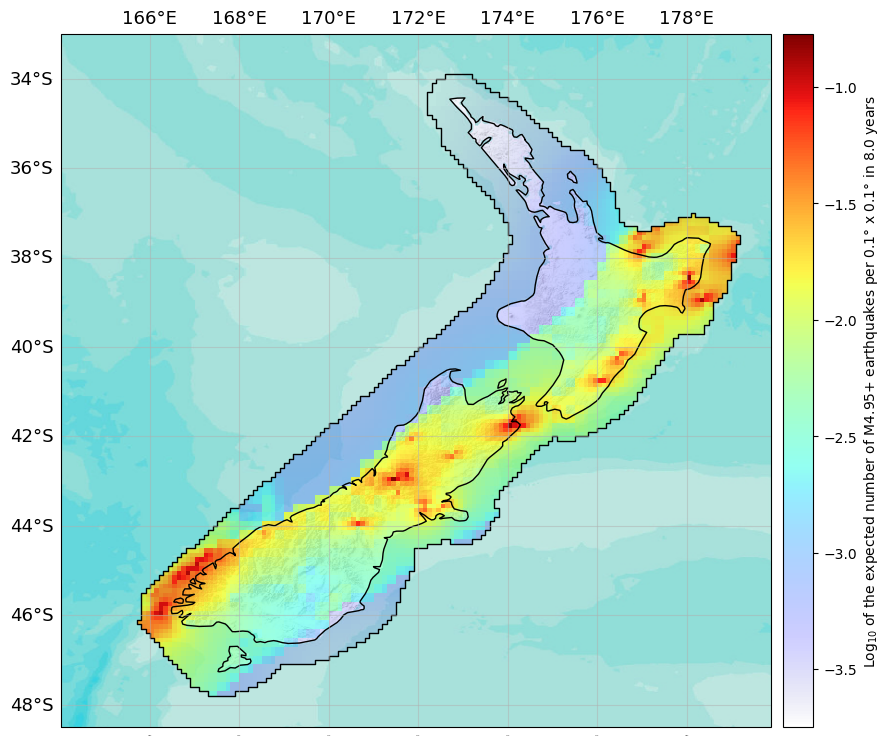

<GeoAxesSubplot:>

In [13]:

fig = plt.figure(figsize=(12,9))

ax_GEAR1NZ = fig.add_subplot(111, projection=ccrs.PlateCarree())
gl = ax_GEAR1NZ.gridlines()
gl.xlines = False
gl.ylines = False
gl.top_labels = True 
gl.bottom_labels = False 
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}
# gl.xlocator = mticker.FixedLocator([166,170, 174, 178])
gl.xformatter = LONGITUDE_FORMATTER
# gl.ylocator = mticker.FixedLocator([-35, -38, -41, -44, -47])
gl.yformatter = LATITUDE_FORMATTER


args_dict = {
            'title': None,
             'grid_labels': True,
             'borders': True,
             'xlabels_top' : True,
             'feature_lw': 0.5,
             'basemap': 'ESRI_terrain',
             'cmap': 'jet',
             'vmin': -4.5,
             'vmax': -0.5,
             'alpha_exp': 0.8,
             'bbox_inches' : 'tight',
             'tight_layout': True,
             'pad_inches':0,
             'filename' : "./output/NZ_GEAR_model",
             'clabel' : f'Log$_{{10}}$ of the expected number of M{GEAR1NZ_f.min_magnitude}+ earthquakes per 0.1° x 0.1° in {duration} years'
            }

GEAR1NZ_f.plot(extent=[164, 179.9,-48.5, -33],
                   show=True,
                   plot_args=args_dict,
                   ax = ax_GEAR1NZ)